# Forecasting de Ventas
### *Javier Ramírez*
---

## Índice

1. Importaciones
2. Preparación de datos
   - Calidad de datos
   - Creación de variables
   - Transformación de datos
3. Entrenamiento e hiperparametrización
4. Validación y resultados de los modelos
5. Prediccione finales


---

## 1. Importaciones

In [1]:
import warnings
# Ignorar todas las advertencias
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from janitor import clean_names

import lightgbm as lgb
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [2]:
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

# Configuración del estilo de seaborn con el diccionario rc
sns.set(rc=rc)

# Definición de colores
color = sns.color_palette('Purples')[3]
paleta = sns.color_palette('seismic')[0:5]

# Configuración de espaciado vertical y horizontal entre subgráficos
plt.rcParams['figure.subplot.hspace'] = 0.33
plt.rcParams['figure.subplot.wspace'] = 0.33

---

## 2. Preparación de Datos

### 2.1. Calidad de datos

In [3]:
def calidad_datos(df, modo = 'entrenamiento'):
    
    df = df.sort_values(['family', 'store_nbr', 'date'])

    # HOLIDAYS

    df[['tipo_holiday', 'locale', 'locale_name', 'description', 'transferred']] = df[['tipo_holiday', 'locale', 'locale_name', 'description', 'transferred']].fillna('Sin festivo')
    
    # INTERPOLATE OIL
    
    oil = df.groupby('date')[['dcoilwtico']].mean()
    oil = oil.interpolate(method='linear')
    oil = oil.fillna(93.14)
    df = df.drop(columns = 'dcoilwtico')
    df = df.merge(oil, how = 'left', on = 'date')

    if modo == 'entrenamiento':
        # ACUMULADO DE LAS VENTAS
        
        sales_acum = df.groupby(['store_nbr', 'date'])[['sales']].sum().reset_index().rename(columns = {'sales':'sales_acum'})
        df = df.merge(sales_acum, how='left', on = ['store_nbr', 'date'])
    
        # TRANSACTIONS
    
        df.loc[(df['transactions'].isna()) & (df['sales_acum'] == 0), 'transactions'] = 0
    
        x = df[['store_nbr', 'date', 'transactions']].drop_duplicates()
    
        def interpolate_group(group):
            return group['transactions'].interpolate(method='linear')
        
        # Aplicar la interpolación a cada grupo
        interpolated_transactions = x.groupby('store_nbr').apply(interpolate_group)
        result = interpolated_transactions.reset_index(level=0, drop=True)
        x['transactions'] = result
        df = df.drop(columns = 'transactions').merge(x, how = 'left', on = ['store_nbr', 'date'])
    
        df = df.drop(columns = 'sales_acum')

    return df

### 2.2. Creación de variables

In [4]:
def creacion_variables(df, modo = 'entrenamiento'):

    # VARIABLES DE LA FECHA

    df['date'] = pd.to_datetime(df['date'])
    
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['year'] = df['date'].dt.year
    df['weekday'] = df['date'].dt.weekday 
    df['day_of_year'] = df['date'].dt.dayofyear
    df['quarter'] = df['date'].dt.quarter  # Trimestre del año
    
    def estacion(x):
        spring = range(80, 172)
        summer = range(172, 264)
        fall = range(264, 355)
        
        if x in spring:
          return 1
        elif x in summer:
          return 2
        elif x in fall:
          return 3
        else:
          return 0
    
    df['season'] = df['day_of_year'].apply(estacion)

    # HOLIDAYS

    df['holiday_navidad'] = df.description.apply(lambda x: 1 if 'navidad' in str(x).lower() else 0)
    df['holiday_carnaval'] = df.description.apply(lambda x: 1 if 'carnaval' in str(x).lower() else 0)
    df['holiday_dia_padre_madre'] = df.description.apply(lambda x: 1 if 'dia de la madre' in str(x).lower() or 'dia del padre' in str(x).lower() else 0)
    df['holiday_cuenca'] = df.description.apply(lambda x: 1 if 'fundacion de cuenca' in str(x).lower() else 0)
    df['holiday_viernes_santo'] = df.description.apply(lambda x: 1 if 'viernes santo' in str(x).lower() else 0)
    df['holiday_primer_dia_ano'] = 0
    df.loc[(df.date.dt.month == 1) & (df.date.dt.day == 1), 'holiday_primer_dia_ano'] = 1

    df['holiday'] = df.locale.isna().astype('int')
    
    # DISCRETIZACIÓN
    
    df['onpromotion_disc'] = pd.cut(df['onpromotion'], bins = 4, labels=False)

    # APERTURA DE LA TIENDA

    if modo == 'entrenamiento':
        df['cerrada'] = df.transactions.apply(lambda x:1 if x == 0 else 0)
    else:
        df['cerrada'] = 0
    
    # ROTURA DE STOCK
    
    def rotura_stock(ventas, n):
        cero_ventas = pd.Series(np.where(ventas == 0,1,0))
        num_ceros = cero_ventas.shift(1).rolling(n).sum()
        rotura_stock = np.where(num_ceros == n,1,0)
        return rotura_stock
    
    df['rotura_stock_20'] = df.groupby(['store_nbr', 'family']).sales.transform(lambda x: rotura_stock(x, 20))
    df['rotura_stock_31'] = df.groupby(['store_nbr', 'family']).sales.transform(lambda x: rotura_stock(x, 31))
    
    # LAGS
    
    df_agrupado = df.groupby(['store_nbr', 'family'])

    alphas = [0.95, 0.8, 0.65, 0.5]
    lags =[1,7,30]
    
    for a in alphas:
        for i in lags:
            df[f'sales_lag_{i}_alpha_{a}'] = np.log1p(df_agrupado['sales'].transform(lambda x: x.shift(i).ewm(alpha=a, min_periods=1).mean()))
    
    # MEDIAS MÓVILES
    
    def custom_mean(series):
        non_zero_values = series[series != 0]  # Filtramos los valores distintos de cero
        return non_zero_values.mean() if len(non_zero_values) > 0 else np.nan
    
    df_agrupado = df[['store_nbr', 'date', 'transactions']].drop_duplicates()

    df_agrupado['transactions_rolling_30'] = df_agrupado.groupby('store_nbr').transactions.shift(1).rolling(window = 30, min_periods = 0).apply(custom_mean)
    df = df.merge(df_agrupado[['store_nbr', 'date', 'transactions_rolling_30']], how = 'left', on = ['store_nbr', 'date'])

    x = df.groupby(['store_nbr', 'date']).sales.sum().reset_index().rename(columns = {'sales':'sales_acum'})
    x['sales_acum_rolling_30'] = x.groupby('store_nbr').sales_acum.shift(1).rolling(window = 30, min_periods = 0).apply(custom_mean)
    df = df.merge(x, how = 'left', on = ['store_nbr', 'date'])
    
    # WAGES
    
    df['wages'] = ((df['date'].dt.day == 15) | df['date'].dt.is_month_end).astype(int)
    
    # TERREMOTO
    
    fecha_inicial = pd.to_datetime('2016-04-16')
    x = pd.Series(df.date.unique())
    
    x = pd.DataFrame((x - fecha_inicial).dt.days + 1).rename(columns = {0:'terremoto'})
    x['date'] = pd.Series(df.date.unique())
    df = df.merge(x, how = 'left', on = 'date')
    df.loc[df.terremoto <= 0, 'terremoto'] = 0


    if modo == 'entrenamiento':
        df = df.dropna()
    df = df.drop(columns = ['transactions', 'sales_acum'])
    df = df.reset_index(drop = True)

    return df

### 2.3. Transformación de datos

In [5]:
def transformar_variables(df, modo = 'entrenamiento'):

    df = df.reset_index(drop = True)

    df['locale_name'] = df.locale_name.map({'Sin festivo':'sin_festivo', 'Ecuador':'ecuador'}).fillna('otro')
    var_ohe = ['store_nbr', 'city', 'state', 'tipo_store', 'cluster', 'tipo_holiday', 'locale', 'locale_name', 'transferred']
    df['transferred'] = df['transferred'].map({'Sin festivo':'sin_festivo', True:'True', False:'False'})

    # ONE HOT ENCODING

    if modo == 'entrenamiento':
        #Si está en entrenamiento aplica fit_transform y guarda el encoder
        ohe = OneHotEncoder(sparse = False, handle_unknown='ignore', drop = 'first')
        ohe_df = ohe.fit_transform(df[var_ohe])
        ohe_df = pd.DataFrame(ohe_df, columns = ohe.get_feature_names_out())
        with open('../Modelos/ohe.pickle', mode='wb') as file:
           pickle.dump(ohe, file)
    else:
        #Si está en ejecución recupera el guardado y solo aplica transform
        with open('../Modelos/ohe.pickle', mode='rb') as file:
            ohe = pickle.load(file)
        ohe_df = ohe.transform(df[var_ohe])
        ohe_df = pd.DataFrame(ohe_df, columns = ohe.get_feature_names_out())

    var_ohe.append('description')
    df = df.drop(columns = var_ohe)
    df = pd.concat([df, ohe_df], axis = 1)
    
    # REESCALADO
    
    ids = df[['id', 'date', 'family', 'sales', 'test']]
    df = df.drop(columns = ['date', 'id', 'family', 'sales', 'test'])

    if modo == 'entrenamiento':
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df)
        df_scaled = pd.DataFrame(df_scaled, columns=df.columns.to_list())
        with open('../Modelos/scaler.pickle', mode='wb') as file:
           pickle.dump(scaler, file)
    else:
        with open('../Modelos/scaler.pickle', mode='rb') as file:
            scaler = pickle.load(file)
        df_scaled = scaler.transform(df)
        df_scaled = pd.DataFrame(df_scaled, columns=df.columns.to_list())
    
    df = pd.concat([ids, df_scaled], axis = 1)
    df = clean_names(df)

    return df

---

## 3. Entrenamiento e Hiperparametrización

In [6]:
# Definición de la función de entrenamiento
def entrenamiento(df):
    diccionario = {}

    # Limpieza y transformación de datos
    df = calidad_datos(df)
    df = creacion_variables(df)
    df = transformar_variables(df)

    # Carga de las variables finales para el modelo desde un archivo pickle
    with open('../Modelos/variables_finales.pickle', 'rb') as archivo:
        variables_finales = pickle.load(archivo)

    # Añadir 'test' a las variables finales para eliminarla posteriormente
    variables_finales.append('test')
    df = df[variables_finales]

    print('Dataframe transformado')
    
    # Iteración sobre cada familia de productos
    lista_familias = df.family.unique()

    for familia in lista_familias:
        
        # Separación de características (X) y variable objetivo (y)
        X = df.loc[(df.family == familia)].drop(columns=['id', 'date', 'family', 'sales', 'test'])
        y = df.loc[(df.family == familia), 'sales']

        # Define la función objetivo para la optimización de los hiperparámetros
        def objective(trial):
            # Definición de los hiperparámetros a optimizar
            params = {
                'objective': 'regression',
                'metric': 'rmse',
                'verbosity': -1,
                'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
                'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
                'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
                'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
                'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
                'n_estimators': trial.suggest_int('n_estimators', 50, 500)
            }
            
            # Ajuste de hiperparámetros específicos según el tipo de boosting
            boosting_type = params['boosting_type']
            if boosting_type != 'goss':
                params['bagging_fraction'] = trial.suggest_uniform('bagging_fraction', 0.4, 1.0)
                params['bagging_freq'] = trial.suggest_int('bagging_freq', 1, 7)
            
            # Validación cruzada de series temporales
            tscv = TimeSeriesSplit(n_splits=3)
            scores = []
            
            # Iteración sobre los splits de entrenamiento y prueba
            for train_index, test_index in tscv.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
                # Inicialización y entrenamiento del modelo LGBMRegressor
                model = lgb.LGBMRegressor(**params, n_jobs=-1)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
            
                # Corrección de valores negativos en las predicciones
                y_pred = np.maximum(y_pred, 0)
            
                # Cálculo de la métrica de evaluación (RMSE)
                score = np.sqrt(mean_squared_log_error(y_test, y_pred))
                scores.append(score)
        
            return np.mean(scores)
        
        # Creación y optimización del estudio Optuna para encontrar los mejores hiperparámetros
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=60)
    
        # Selección del mejor trial del estudio
        trial = study.best_trial
    
        # Reentrenamiento del mejor modelo sobre todos los datos
        modelo_final = lgb.LGBMRegressor(**trial.params, n_jobs=-1)
        modelo_final = modelo_final.fit(X, y)
        diccionario[familia] = modelo_final

        print(f'{familia} entrenada')

    # Guardado del diccionario de modelos entrenados en un archivo pickle
    with open('../Modelos/dict_modelos.pickle', mode='wb') as file:
        pickle.dump(diccionario, file)

In [ ]:
# Extraer el dataset
df = pd.read_csv('../Datos/train.csv', parse_dates = ['date'])
df = df.loc[(df.date >= '2015-01-01') & (df.date < '2017-08-01')]
df['test'] = 0

# Entrenamiento
entrenamiento(df)

---

## 4. Validación y resultados de los Modelos

### 4.1. Realizar las predicciones

In [8]:
# Definición de la función para ejecutar predicciones
def ejecutar_predicciones(df, modelos):
    # Carga del diccionario de modelos desde un archivo pickle
    with open(f'../Modelos/{modelos}.pickle', mode='rb') as file:
        dict_modelos = pickle.load(file)

    # Ordenación del DataFrame
    df = df.sort_values(by=['date', 'family', 'store_nbr'])
    
    # Limpieza, creación y transformación de variables para ejecución
    df = calidad_datos(df, 'ejecucion')
    df = creacion_variables(df, 'ejecucion')
    df = transformar_variables(df, 'ejecucion')

    # Carga de las variables finales desde un archivo pickle
    with open('../Modelos/variables_finales.pickle', 'rb') as archivo:
        variables_finales = pickle.load(archivo)

    variables_finales.append('test')
    df = df[variables_finales]
    
    print('Dataframe transformado')
    
    # DataFrame para almacenar las predicciones
    df_predicciones = pd.DataFrame()
    
    # Iteración sobre cada familia de productos
    for familia in df.family.unique():

        # Selección de características y variable objetivo para el conjunto de prueba
        X_test = df.loc[(df.test == 1) & (df.family == familia)].drop(columns=['id', 'date', 'family', 'sales', 'test'])
        y_test = df.loc[(df.test == 1) & (df.family == familia), ['sales', 'id', 'test', 'family', 'date']]
            
        modelo = dict_modelos[familia]
    
        # Predicción de las ventas utilizando el modelo correspondiente
        y_pred = modelo.predict(X_test)
    
        # Creación del DataFrame de predicciones para la familia actual
        prediccion = pd.DataFrame({'id': y_test.id, 'date': y_test.date, 'family': y_test.family, 'sales': y_test.sales, 'prediccion': y_pred})
    
        # Concatenación de las predicciones al DataFrame general
        df_predicciones = pd.concat([df_predicciones, prediccion], axis=0)

    # Reset del índice del DataFrame de predicciones y retorno del resultado
    return df_predicciones.reset_index(drop=True)


In [ ]:
# Preparar el dataset para que quede igual que el de test
df = pd.read_csv('../Datos/train.csv', parse_dates = ['date'])
validacion = df.loc[df.date >= '2017-08-01']
validacion_original = validacion.copy()
validacion_original = validacion_original.sort_values(by = ['family', 'store_nbr', 'date'])
df = df.loc[(df.date >= '2016-01-01') & (df.date < '2017-08-01')]
df['test'] = 0
validacion['test'] = 1
validacion['sales'] = np.nan
validacion['transactions'] = np.nan
df_validacion = pd.concat([df, validacion], axis = 0)

# Realizar las predicciones
df_predicciones = ejecutar_predicciones(df_validacion, 'dict_modelos')

# Sustituir los valores negativos por 0
df_predicciones.loc[df_predicciones.prediccion < 0, 'prediccion'] = 0

### 4.2. Evaluar los resultados

In [10]:
y_pred = df_predicciones.prediccion.reset_index(drop = True)
y_true = validacion_original.sales.reset_index(drop = True)

# Raiz del error logarítmico cuadrático medio
rmsle = np.sqrt(mean_squared_log_error(validacion_original.sales, df_predicciones.prediccion))

# Error cuadrático medio (MSE)
mse = mean_squared_error(y_true, y_pred)

# Error absoluto medio (MAE)
mae = mean_absolute_error(y_true, y_pred)

# Raíz del error cuadrático medio (RMSE)
rmse = np.sqrt(mse)

# Error porcentual absoluto medio escalado (SMAPE)
smape = 2 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

# Imprimir resultados
print(f"Raíz del error logaritmico cuadrático medio (RMSLE): {round(rmsle, 4)}")
print(f"Error cuadrático medio (MSE): {round(mse, 2)}")
print(f"Raíz del error cuadrático medio (RMSE): {round(rmse, 2)}")
print(f"Error absoluto medio (MAE): {round(mae, 2)}")
print(f"Error porcentual absoluto medio escalado (SMAPE): {round(smape, 2)}%")

Raíz del error logaritmico cuadrático medio (RMSLE): 0.4433
Error cuadrático medio (MSE): 87176.69
Raíz del error cuadrático medio (RMSE): 295.26
Error absoluto medio (MAE): 87.38
Error porcentual absoluto medio escalado (SMAPE): 57.81%


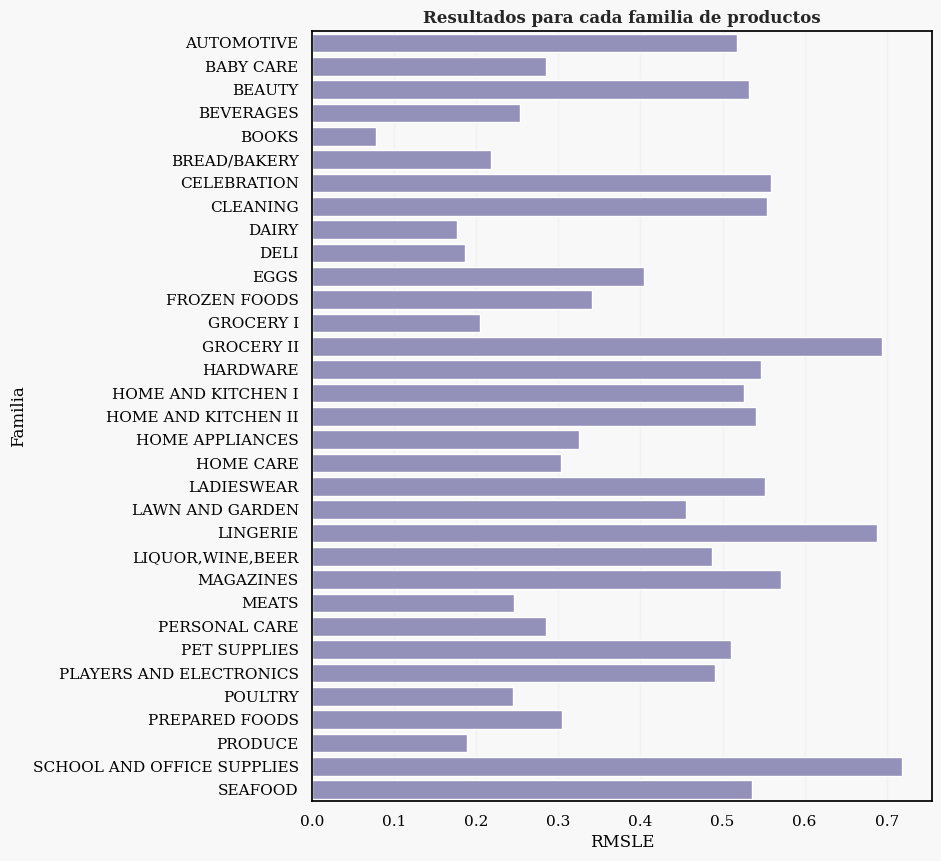

In [11]:
# Añade la columna 'sales' al dataframe de resultados
df_predicciones['sales'] = y_true

# Inicializa una lista para almacenar los resultados de RMSLE
resultados_rmsle = []

# Calcula el RMSLE para cada familia
for family in df_predicciones['family'].unique():
    # Filtra el dataframe por la familia actual
    df_family = df_predicciones[df_predicciones['family'] == family]
    
    # Calcula el RMSLE para la familia actual
    rmsle = np.sqrt(mean_squared_log_error(df_family['sales'], df_family['prediccion']))
    
    # Almacena el resultado en la lista de resultados
    resultados_rmsle.append({'Familia': family, 'RMSLE': rmsle})

# Crea un dataframe a partir de la lista de resultados
resultados = pd.DataFrame(resultados_rmsle)

# Muestra el dataframe de resultados
plt.figure(figsize = (8, 10))
sns.barplot(data = resultados, x = 'RMSLE', y = 'Familia', color = color)
plt.title('Resultados para cada familia de productos', fontsize=12, fontweight="bold");

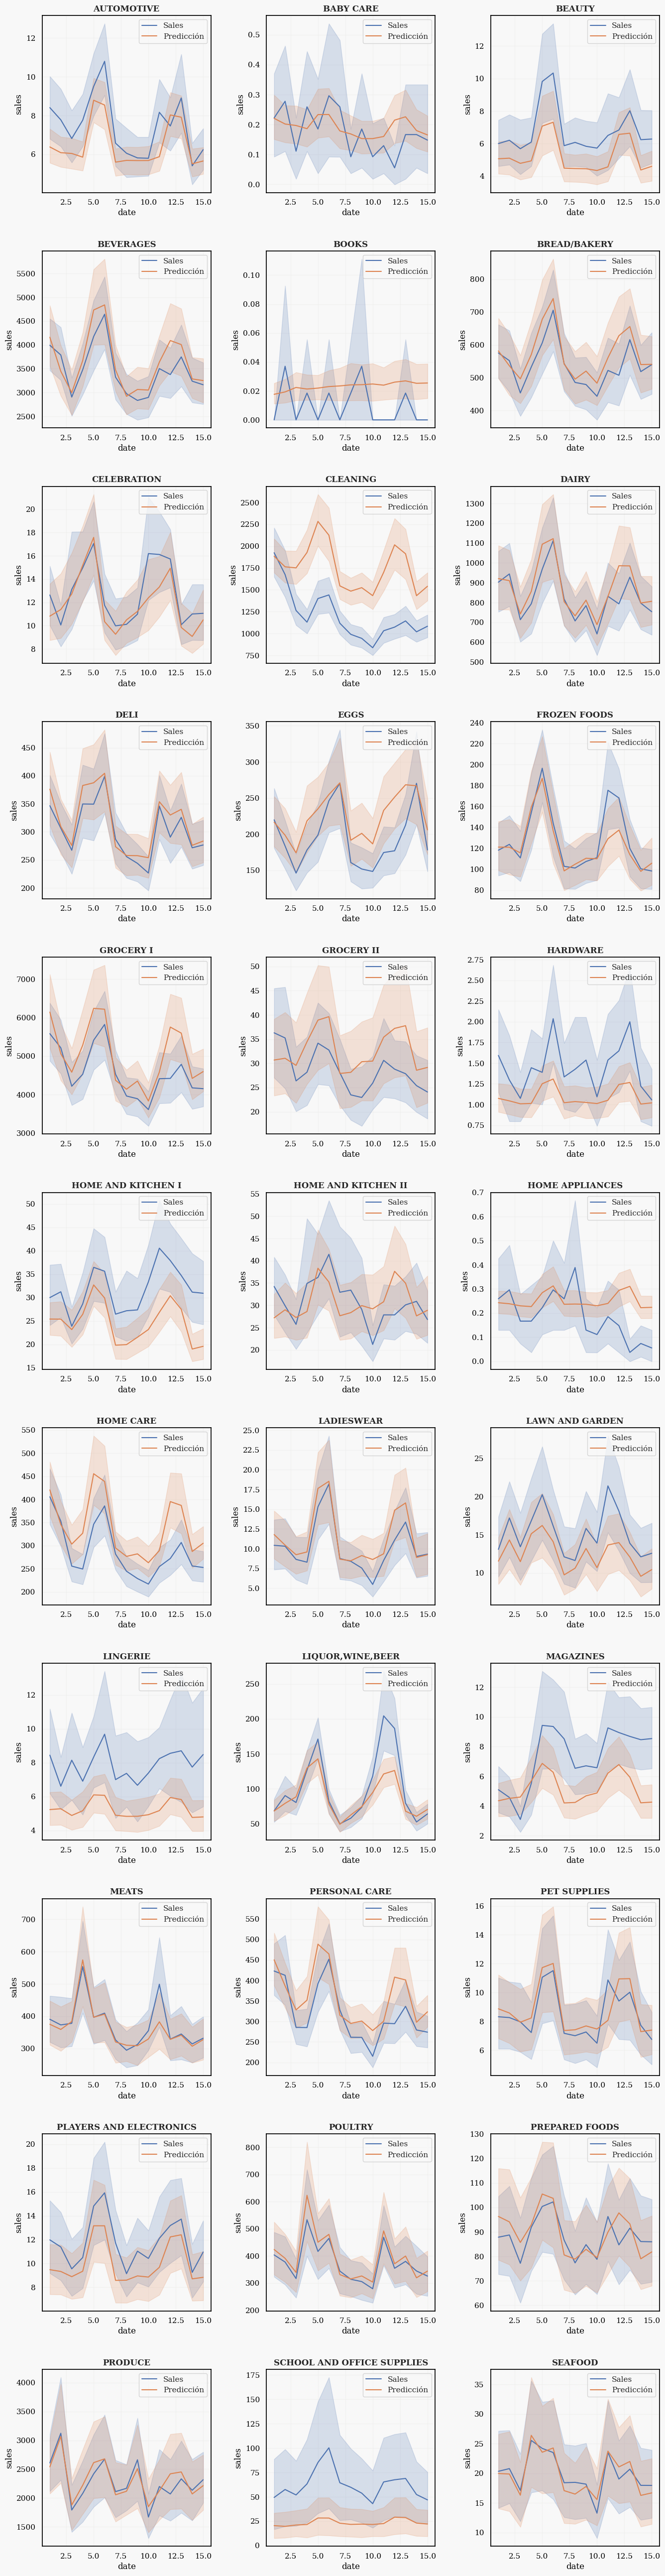

In [12]:
# Creación de una figura con múltiples subgráficos
f, ax = plt.subplots(nrows=11, ncols=3, figsize=(16, 66))
ax = ax.flat 

# Iteración sobre cada familia de productos
for n, family in enumerate(df_predicciones.family.unique()):
    df_family = df_predicciones.loc[df_predicciones.family == family]
    
    # Gráficos de las ventas reales y predicciones para cada familia
    sns.lineplot(ax=ax[n], x=df_family.date.dt.day, y=df_family.sales, label='Sales')
    sns.lineplot(ax=ax[n], x=df_family.date.dt.day, y=df_family.prediccion, label='Predicción')
    ax[n].set_title(family, fontsize=12, fontweight="bold")
    ax[n].legend()

---

## 5. Predicciones Finales

In [ ]:
# Extraer y preparar el dataset
df = pd.read_csv('../Datos/train.csv', parse_dates = ['date'])
df = df.loc[(df.date >= '2016-01-01')]
df['test'] = 0
df_test = pd.read_csv('../Datos/test.csv', parse_dates = ['date'])
df_test['test'] = 1
df_test = pd.concat([df, df_test], axis = 0)

# Realizar las predicciones
df_predicciones_test = ejecutar_predicciones(df_test, 'dict_modelos')

In [14]:
# Preparar el dataset para la entrega
submission = df_predicciones_test[['id', 'prediccion']].rename(columns = {'prediccion':'sales'}).sort_values('id')
submission.loc[submission.sales < 0, 'sales'] = 0
submission.head()

,id,sales
0,3000888,3.546244
864,3000889,0.002459
1728,3000890,3.795859
2592,3000891,2119.509217
3456,3000892,0.028777


In [15]:
# Guardar el dataset con las predicciones
submission.to_csv('../submission.csv', index = False)